# Сборный проект

###### Цель проекта
Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Исследовать результаты A/A/B-эксперимента и принять решение по его результатам.

###### Описание данных
Каждая запись в логе — это действие пользователя, или событие.
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

---

## 1. Импортируем библиотеки. Загрузим данные и подготовим их к анализу.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
logs.columns=['event','id','timestamp','group']
logs['dt'] = pd.to_datetime(logs['timestamp'], unit = 's')
logs['date'] = logs['dt'].astype('datetime64[D]')

In [5]:
logs.duplicated().sum()

413

In [6]:
logs = logs.drop_duplicates().reset_index(drop = True)

In [7]:
logs.head()

,event,id,timestamp,group,dt,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Поменяли названия столбцов на более удобные, удалили дубликаты и заменили типы данных там, где это необходимо.

---

## 2. Изучим и проверим данные

Посмотрим: 
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?

In [9]:
print('Всего событий в логе %d, типов событий в логе %d.' % (logs.shape[0], logs['event'].nunique()))

Всего событий в логе 243713, типов событий в логе 5.


In [10]:
print('Всего пользователей в логе %d.' % (logs['id'].nunique()))

Всего пользователей в логе 7551.


In [11]:
print('В среднем событий на пользователя %d.' % (logs.shape[0] / logs['id'].nunique()))

В среднем событий на пользователя 32.


---

Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросим более старые.

In [12]:
display('Дата начала теста {}'.format(logs['dt'].min()))
display('Дата окончания теста {}'.format(logs['dt'].max()))

'Дата начала теста 2019-07-25 04:43:36'

'Дата окончания теста 2019-08-07 21:15:17'

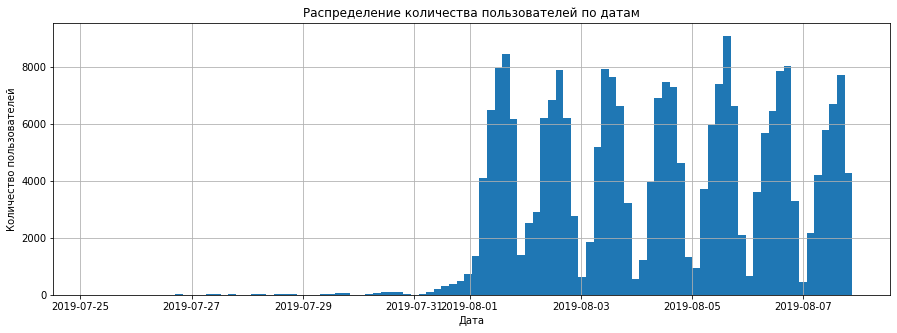

In [13]:
logs['dt'].hist(bins=100, figsize=(15,5))
plt.title('Распределение количества пользователей по датам')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.show()

Согласно гистограмме у нас почти нет данных за первую неделю. Корректно отсечь данные за июль и использовать только август. Посмотрим на обновленные данные.

In [14]:
df = logs.query('dt >= "2019-08-01"')

In [15]:
df.head()

,event,id,timestamp,group,dt,date
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


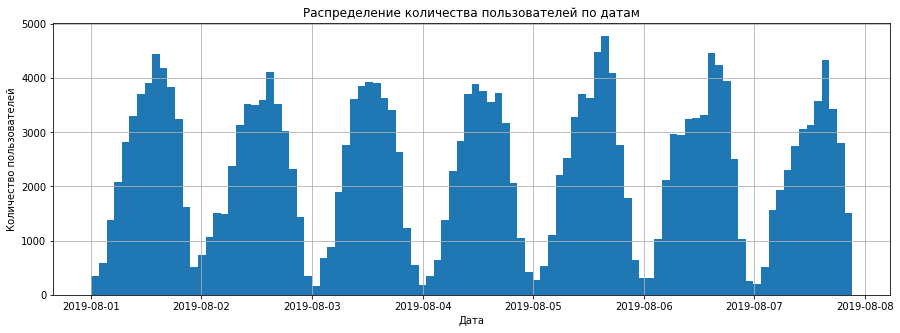

In [18]:
df['dt'].hist(bins=100, figsize=(15,5))
plt.title('Распределение количества пользователей по датам')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.show()


---

Посмотрим много ли событий и пользователей мы потеряли, отбросив старые данные.

In [19]:
logs['id'].nunique() - df['id'].nunique()

17

In [20]:
logs['event'].count() - df['event'].count()

2826

Отбросив неактуальные данные мы потеряли лишь 17 пользователей, на которых приходилось 2926 событий.

---

Проверим, что у вас есть пользователи из всех трёх экспериментальных групп.


In [21]:
df['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

In [22]:
df.groupby('group').agg({'id':'nunique'})

,id
group,
246,2484
247,2513
248,2537


С этим все в порядке, пользователи из всех трёх экспериментальных групп присутсвуют в данных.

---

Изучив данные, можно сделать следующие выводы: 
- В логе 5 типов событий;
- Всего событий 243713;
- Пользователей в логе 7551;
- В среднем событий на пользователя 32;
- Данные представлены за две недели, из которых лишь во второй неделе данные являются полными. Поэтому мы отсекли данные за первую неделю;
- Отбросив неактуальные данные мы потеряли лишь 17 пользователей, на которых приходилось 2926 событий;
- В данных остались пользователи из всех трёх групп.


----

## 3. Изучим воронку событий


Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [23]:
df['event'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event, dtype: int64

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [24]:
events_per_user = (df
                    .groupby('event')
                    .agg({'id':'nunique'})
                    .sort_values(by='id',
                                 ascending=False)
                   )

events_per_user['ratio'] = ((events_per_user['id'] / df['id'].nunique()).map('{:.2%}'.format))
events_per_user

,id,ratio
event,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%
Tutorial,840,11.15%


Видим, что не все пользователи попадают на Главный экран, возможно это связано с тем что пользователи начали сессию и продолжили её спустя время, минуя событие с главным экраном. Событие туториал совершали лишь **11%** пользователей, по всей видимосьти это событие не обязательное и происходит по желанию пользователя, в дальнейшем мы его рассматривать не будем. 

События происходят в следующем порядке:

- **MainScreenAppear** - появление главного экрана;
- **OffersScreenAppear** - предложение о товаре;
- **CartScreenAppear** - переход в корзину;
- **PaymentScreenSuccessful** - экран успешной оплаты заказа.


---

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем шаге.

Посмотрим:
- На каком шаге теряется больше всего пользователей?

- Какая доля пользователей доходит от первого события до оплаты?

In [25]:
events_per_users = (df
                    .query('event != "Tutorial"')
                    .groupby('event')
                    .agg({'id':'nunique'})
                    .sort_values(by='id',
                                 ascending=False)
                   )

events_per_users = events_per_users[['id']].assign(ratio=events_per_users['id'].pct_change().add(1))
events_per_users

,id,ratio
event,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,0.619086
CartScreenAppear,3734,0.812976
PaymentScreenSuccessful,3539,0.947777


Больше всего мы теряем пользователей после первого шага из главного экрана MainScreenAppear в предложение OffersScreenAppear. 
А именно **38%** пользователей.

In [26]:
events_per_users['ratio'].cumprod()

event
MainScreenAppear                NaN
OffersScreenAppear         0.619086
CartScreenAppear           0.503302
PaymentScreenSuccessful    0.477018
Name: ratio, dtype: float64

**47,7%** доля пользователей которые дошли от первого события до успешной оплаты.

---


Изучив воронку событий, можно сделать следующие выводы:
- Самым частым событием является появление Главного экрана, на него попадают **98.47%** от общего числа пользователей;
- Туториал не пользуется спросом у пользователей и это событие совершили лишь **11%** пользователей;
- События происходят в таком порядке **MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful**;
- Больше всего пользователей теряется на первом шаге из главного экрана на экран предложения, а именно **38%**;
- Доля пользователей дошедших от первого события до успешной оплаты - **47,7%**.


----

##  4. Изучим результаты эксперимента


Посмотрим сколько пользователей в каждой экспериментальной группе. Для дальнейшего удобства добавим новую строку с обьединенной группой.

In [24]:
df['group'] = df['group'].astype(str).str.replace('246', 'A1').str.replace('247', 'A2').str.replace('248', 'B')
users = df.groupby('group').agg({'id':'nunique'})
users.loc['A']= users.sum() - users.loc['B']
users

,id
group,
A1,2484
A2,2513
B,2537
A,4997


Расхождения между контрольными группами незначительные, можно продолжать.

---

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Посчитаем число пользователей, совершивших все события в каждой из контрольных групп. Уберем событие туториал, так как нас данное событие не интересует. Проверим, будет ли отличие между группами статистически достоверным.

In [25]:
conversion = (df
              .pivot_table(index = 'event',
                           columns = 'group',
                           values = 'id',
                           aggfunc = 'nunique')
              .rename_axis(None, axis=1)
              .sort_values(by='A1', ascending=False)
             )
conversion['A'] = conversion['A1'] + conversion['A2']
conversion=conversion.query('event != "Tutorial"')
conversion

,A1,A2,B,A
event,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Напишем функцию, для проверки статистический отличий между группами.

In [26]:
def z_test(group1, group2, event, alpha): 
    x1 = conversion.loc[event, group1]
    x2 = conversion.loc[event, group2] 
    n1 = users.loc[group1, 'id'] 
    n2 = users.loc[group2, 'id'] 
    p1 = x1 / n1 
    p2 = x2 / n2 
    difference = p1 - p2
    p_combined = (x1 + x2) / (n1 + n2) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / n1 + 1 / n2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(group1, group2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Здесь и далее будем считать  нулевую и альтернативную гипотезы следующими:

- H0 - между долями НЕТ статистически значимых различий
- H1 - между долями ЕСТЬ статистически значимые различия
- Примем для себя уровень значимости alpha = 0.05 
- Так как у нас происходит множественная проверка гипотез воспользуемся методом поправки Бонферрони и принятый уровень значимости alpha разделим на количество рассматриваемых гипотез(по 4 для каждого сравнения)

In [27]:
for event in conversion.index:
    z_test('A1', 'A2', event, 0.05 / (conversion.shape[0] * 4))
    print()

Проверка для групп A1 и A2, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A1 и A2, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A1 и A2, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A1 и A2, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу



Тест проведен корректно - статистически значимых различий между двумя А-группами не обнаружено.

---

Аналогично поступим с группой с изменённым шрифтом:
- Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
- Сравним результаты с объединённой контрольной группой.

In [28]:
for event in conversion.index:
    z_test('A1', 'B', event, 0.05 / (conversion.shape[0] * 4))
    print()

Проверка для групп A1 и B, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A1 и B, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A1 и B, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A1 и B, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу



In [29]:
for event in conversion.index:
    z_test('A2', 'B', event, 0.05 / (conversion.shape[0] * 4))
    print()

Проверка для групп A2 и B, событие: MainScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A2 и B, событие: OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A2 и B, событие: CartScreenAppear, p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу



In [30]:
for event in conversion.index:
    z_test('A', 'B', event, 0.05 / (conversion.shape[0] * 4))
    print()

Проверка для групп A и B, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A и B, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A и B, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу

Проверка для групп A и B, событие: PaymentScreenSuccessful, p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу



Так как у нас происходила множественная проверка гипотез мы использовали метод поправки Бонферрони и принятый уровень значимости alpha был поделен на количество рассматриваемых гипотез по 4 для каждого сравнения, в общей сложности 16. 

При таком уровне значимости, ни в одном из проведенных тестов не нашлось статистически значимых различий.

---

## 5. Вывод

Была проведена подготовка данных к анализу: поменяли названия столбцов на более удобные, удалили дубликаты и заменили типы данных там, где это необходимо.

Изучив данные и проверив их, мы выяснили следующее: 
- В логе 5 типов событий;
- Всего событий 243713;
- Пользователей в логе 7551;
- В среднем событий на пользователя 32.

Было принято решение отбросить данные за первую неделю из-за их неполноты, при этом мы потеряли **17** пользователей, на которых приходилось **2926** события, что для нас приемлемо, так как в данных остались пользователи из всех трёх групп с незначительными расхождениями.

Далее была изучена воронка событий, по которой можно сказать следующее:

- Самым частым событием является появление Главного экрана, на него попадают **98.47%** от общего числа пользователей;
- События происходят в таком порядке **MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful**;
- Больше всего пользователей теряется на первом шаге из главного экрана на экран предложения, а именно 38%;
- Доля пользователей дошедших от первого события до успешной оплаты - 47,7%.

Туториал не пользуется спросом у пользователей и это событие совершили лишь **11%** пользователей, поэтому это событие не представляет для нас ценность и мы его исключили из дальнейшего исследования.

Вывод по результатам эксперимента: 

Тест можно считать успешным, мы выяснили что между группами **A** и **B** нет статистических различий, внесённые нами изменение шрифта на главной странице никак **не повлияли** на конверсию и на поведение пользователей. Поэтому не стоит применять эти изменения ко всему ресурсу - они не принесут никакой выгоды бизнесу. 

Учитывая что у нас данные только за одну неделю, стоит пособирать ещё данных и провести повторное сравнение экспериментальных групп, например за **2 недели**.